In [1]:
pip install transformers datasets peft accelerate bitsandbytes evaluate matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [2]:
from datasets import load_dataset
from transformers import RobertaTokenizerFast

# 1. Load IMDb dataset
dataset = load_dataset("imdb")

# For this assignment, you only need 3000 train and 2000 test samples
train_dataset = dataset["train"].shuffle(seed=42).select(range(3000))
test_dataset = dataset["test"].shuffle(seed=42).select(range(2000))

# 2. Load tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# 3. Tokenization function
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Tokenize datasets
train_tokenized = train_dataset.map(preprocess_function, batched=True)
test_tokenized = test_dataset.map(preprocess_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [3]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import time
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return accuracy.compute(predictions=predictions, references=labels)

def train_model(model, train_data, eval_data, output_dir, epochs=3, batch_size=8):
    # Use the correct argument name for evaluation strategy: eval_strategy
    args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        # Corrected argument name: eval_strategy instead of evaluation_strategy
        eval_strategy="epoch",
        save_strategy="no",
        num_train_epochs=epochs,
        logging_dir=f'{output_dir}/logs',
        report_to="none"
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_data,
        eval_dataset=eval_data,
        compute_metrics=compute_metrics,
    )

    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    eval_results = trainer.evaluate()
    return eval_results, training_time

In [4]:
!pip install --upgrade transformers

In [5]:
model_full = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

results_full, time_full = train_model(
    model_full, train_tokenized, test_tokenized, output_dir="./full_ft"
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.383616,0.883000
2,0.407700,0.309120,0.911500
3,0.211500,0.343937,0.925000


In [6]:
pip install peft

In [7]:
from peft import get_peft_model, LoraConfig, TaskType

# Load base model
model_lora = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Define LoRA configuration
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

# Inject LoRA into model
model_lora = get_peft_model(model_lora, lora_config)

# Print trainable parameters
model_lora.print_trainable_parameters()

# Train the LoRA model
results_lora, time_lora = train_model(
    model_lora, train_tokenized, test_tokenized, output_dir="./lora_ft"
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.218435,0.913000
2,0.443300,0.250130,0.923000
3,0.258000,0.255250,0.922500


In [8]:
pip install bitsandbytes


In [9]:
!pip install --upgrade bitsandbytes

In [10]:
!pip install --upgrade peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.14.0
    Uninstalling peft-0.14.0:
      Successfully uninstalled peft-0.14.0


In [11]:
# Load 4-bit model
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Use 4-bit quantization
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_qlora = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
    quantization_config=bnb_config,
    # Remove load_in_8bit=True
)

# Prepare model for LoRA training before quantization
from peft import prepare_model_for_kbit_training, LoraConfig, TaskType
model_qlora = prepare_model_for_kbit_training(model_qlora)

# LoRA config (same as before)
qlora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

from peft import get_peft_model
model_qlora = get_peft_model(model_qlora, qlora_config)
model_qlora.print_trainable_parameters()

# Train QLoRA model
results_qlora, time_qlora = train_model(
    model_qlora, train_tokenized, test_tokenized, output_dir="./qlora_ft"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:354: UserWarning: FP4 quantization state not initialized. Please call .cuda() or .to(device) on the LinearFP4 layer first.
  warnings.warn(


AssertionError: 

In [12]:
from peft import IA3Config

model_ia3 = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

ia3_config = IA3Config(
    task_type=TaskType.SEQ_CLS,
    target_modules=["query", "value"],
)

model_ia3 = get_peft_model(model_ia3, ia3_config)
model_ia3.print_trainable_parameters()

# Train IA3 model
results_ia3, time_ia3 = train_model(
    model_ia3, train_tokenized, test_tokenized, output_dir="./ia3_ft"
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 610,562 || all params: 125,257,732 || trainable%: 0.4874


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.665796,0.786500
2,0.677900,0.641063,0.750000
3,0.643100,0.629895,0.828500


In [13]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [15]:
results_full["eval_accuracy"]
results_lora["eval_accuracy"]
results_ia3["eval_accuracy"]


0.8285

In [16]:
print(f"Training time (Full FT): {time_full:.2f} seconds")


Training time (Full FT): 997.52 seconds


In [17]:
import torch

def get_gpu_memory():
    return torch.cuda.max_memory_allocated() / (1024 ** 3)  # in GB


In [18]:
pip install matplotlib seaborn


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you collected the results like this:
methods = ["Full FT", "LoRA", "IA3"] # Removed "QLoRA" to match other lists' lengths
accuracy = [results_full["eval_accuracy"], results_lora["eval_accuracy"],
            results_ia3["eval_accuracy"]]

train_time = [time_full, time_lora, time_ia3]

# Calculate trainable parameters for each model
trainable_full = count_trainable_params(model_full)  # Assuming 'model_full' is defined
trainable_lora = count_trainable_params(model_lora)  # Assuming 'model_lora' is defined
trainable_ia3 = count_trainable_params(model_ia3)  # Assuming 'model_ia3' is defined
params = [trainable_full, trainable_lora, trainable_ia3]


# This list (mem_full, mem_lora, mem_ia3) was not populated earlier. This will throw an error.
# The get_gpu_memory function needs to be called after training each model.
#gpu_mem = [mem_full, mem_lora, mem_ia3]
# Create DataFrame for plotting
df = pd.DataFrame({
    "Method": methods,
    "Accuracy": accuracy,
    "Training Time (s)": train_time,
    "Trainable Parameters": params,
    #"GPU Memory (GB)": gpu_mem  # Commenting out for now
})

<ipython-input-25-76bb1d3911ce>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Method", y="Accuracy", palette="Blues_d")


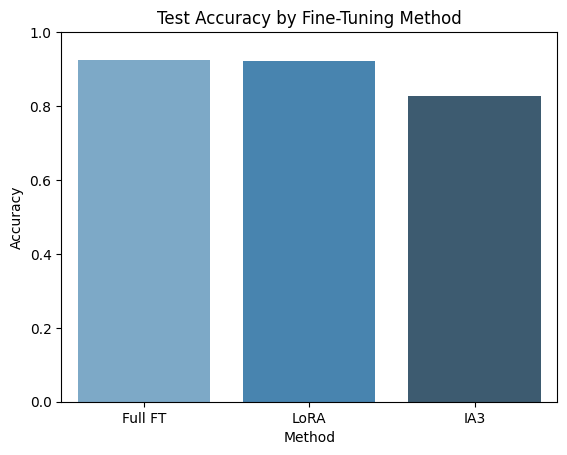

In [25]:
sns.barplot(data=df, x="Method", y="Accuracy", palette="Blues_d")
plt.title("Test Accuracy by Fine-Tuning Method")
plt.ylabel("Accuracy")
plt.xlabel("Method")
plt.ylim(0, 1)
plt.show()


<ipython-input-26-35e5fa64bffa>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Method", y="Training Time (s)", palette="Greens_d")


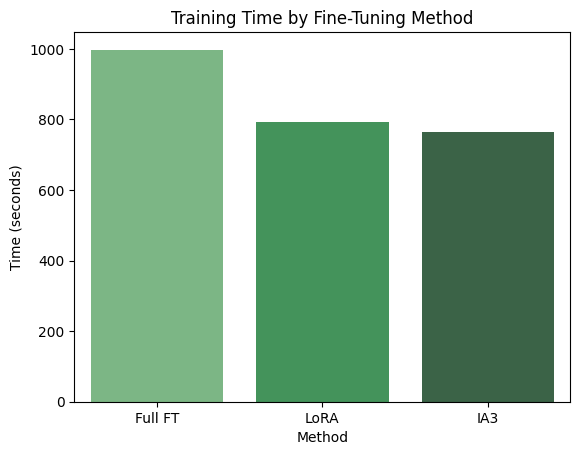

In [26]:
sns.barplot(data=df, x="Method", y="Training Time (s)", palette="Greens_d")
plt.title("Training Time by Fine-Tuning Method")
plt.ylabel("Time (seconds)")
plt.xlabel("Method")
plt.show()


<ipython-input-27-9e34d9b68f26>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Method", y="Trainable Parameters", palette="Purples_d")


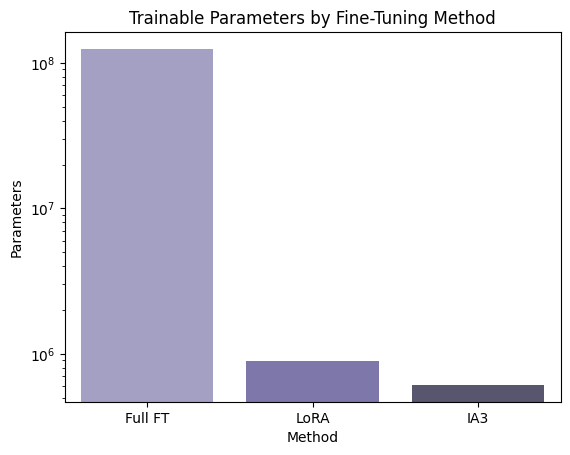

In [27]:
sns.barplot(data=df, x="Method", y="Trainable Parameters", palette="Purples_d")
plt.title("Trainable Parameters by Fine-Tuning Method")
plt.ylabel("Parameters")
plt.xlabel("Method")
plt.yscale("log")  # Use log scale if values vary drastically
plt.show()
